In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from glob import glob
from os import path
from scipy import stats
from tqdm import tqdm
#import cupy as cp
import distance as dist_cpu
#import distance_gpu as dist_gpu
import matplotlib.pyplot as plt
import os

from utils import *

## Setup

In [3]:
def discard_bottom(a: cp.ndarray, cap: float|None = None) -> cp.ndarray:
    """
    Assuming array is in range [0,1], clamps it to [cap,1], then rescales back
    to [0,1]. If cap is None, it is set to 5th percentile of the data.
    """
    if cap is None:
        cap = cp.percentile(a, q=5)
    return (cp.maximum(a - cap, 0)) / (1 - cap)

In [4]:
C = 0.8
metrics = [
    #("Jaccard", lambda votes: dist_gpu.jaccard(votes, votes), "jaccard", "%s, Jaccard"),
    #("Cosine", lambda votes: dist_gpu.cosine(votes, votes), "cosine", "%s, Cosine"),
    #("Simrank", lambda votes: dist_gpu.simrank(votes, C1=C, C2=C, max_iter=1000), "simrank", f"%s, Simrank (C={C})"),
    ("Jaccard", lambda votes: dist_gpu.jaccard(votes.T, votes.T), "jaccard", "%s, Jaccard"),
    ("Cosine", lambda votes: dist_gpu.cosine(votes.T, votes.T), "cosine", "%s, Cosine"),
    ("Simrank", lambda votes: dist_gpu.simrank(votes.T, C1=C, C2=C, max_iter=1000), "simrank", f"%s, Simrank (C={C})"),
    #("Jaccard (normalized)", lambda votes: discard_bottom(dist_gpu.jaccard(votes, votes)), "jaccard_norm", "%s, Jaccard (normalized)"),
    #("Cosine (normalized)", lambda votes: discard_bottom(dist_gpu.cosine(votes, votes)), "cosine_norm", "%s, Cosine (normalized)"),
    #("Simrank (normalized)", lambda votes: discard_bottom(dist_gpu.simrank(votes, C1=C, C2=C, max_iter=1000), 1-C), "simrank_norm", f"%s, Simrank (C={C}, normalized)"),
    #("Jaccard (-0.5)", lambda votes: discard_bottom(dist_gpu.jaccard(votes, votes), 0.5), "jaccard_05", "%s, Jaccard (-0.5)")
]

## Histograms

### Individual instances

In [8]:
def save_histogram(dist: np.ndarray, title: str, filename: str, meta) -> None:
    fig, ax = plt.subplots()
    plt.title(title)
    plt.hist(
        dist.reshape(-1),
        range=(0,1),
        bins=100,
        density=True,
    )
    plt.text(
        0.02,
        0.98,
        f"voters = {meta['num_votes']}\n"
        f"projects = {meta['num_projects']}\n"
        f"min_length = {meta.get('min_length', None)}\n"
        f"max_length = {meta.get('max_length', None)}",
        ha='left',
        va='top',
        transform=ax.transAxes
    )
    plt.savefig(filename, dpi=150)
    plt.clf()
    plt.close()

In [ ]:
meta, projects, votes = load_pb_ohe('data/poland_warszawa_2023_bielany.pb')
d = dist_cpu.jaccard(votes, votes)

In [11]:
save_histogram(d, 'poland_warszawa_2023_bielany, Jaccard', 'histograms/jaccard/poland_warszawa_2023_bielany.png', meta)

In [7]:
for name, metric, dirname, title in metrics[6:]:
    failures = []
    for file in tqdm(glob('./data_all/*.pb'), desc=name):
        meta, projects, votes = load_pb_ohe(file)
        votes = cp.asarray(votes)
        basename = path.splitext(path.basename(file))[0]

        try:
            dist = metric(votes)
        except Exception as e:
            # print(e)
            failures.append(file)
            del meta, projects, votes
            continue

        save_histogram(dist, title % basename, f"histograms_projects/{dirname}/{basename}.png", meta)
        del meta, projects, votes, dist
    print(f"{name} failed on {len(failures)} files.")

Jaccard (-0.5):   0%|          | 0/589 [00:00<?, ?it/s]

Jaccard (-0.5): 100%|██████████| 589/589 [03:07<00:00,  3.15it/s]

Jaccard (-0.5) failed on 118 files.


### Combined CDF

Jaccard:   0%|          | 0/589 [00:00<?, ?it/s]

Jaccard: 100%|██████████| 589/589 [01:33<00:00,  6.31it/s]

Jaccard failed on 133 files.


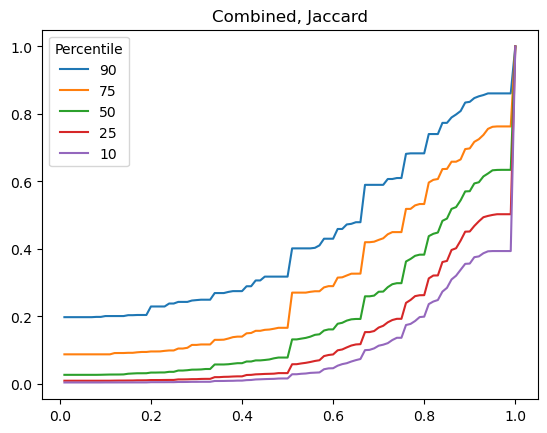

Cosine: 100%|██████████| 589/589 [02:56<00:00,  3.34it/s]

Cosine failed on 14 files.


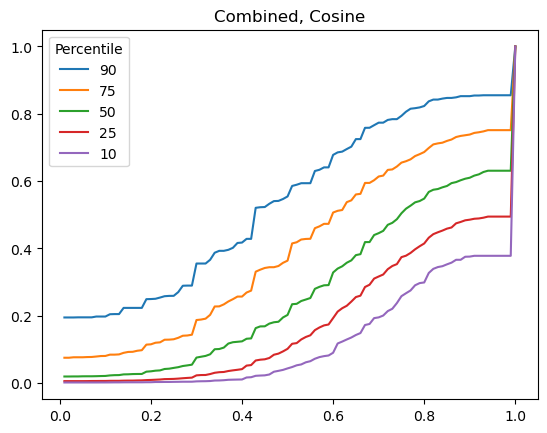

Simrank: 100%|██████████| 589/589 [10:01<00:00,  1.02s/it]


Simrank failed on 24 files.


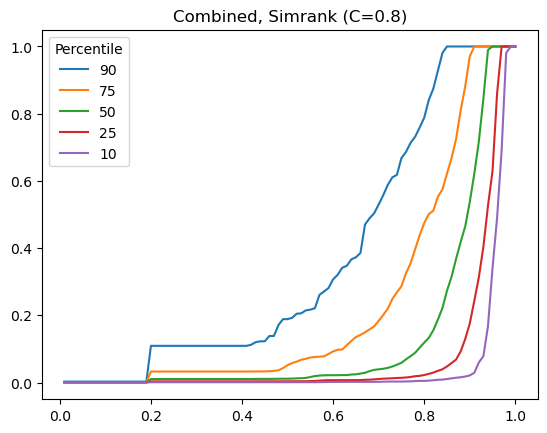

Jaccard (normalized): 100%|██████████| 589/589 [01:40<00:00,  5.84it/s]

Jaccard (normalized) failed on 123 files.


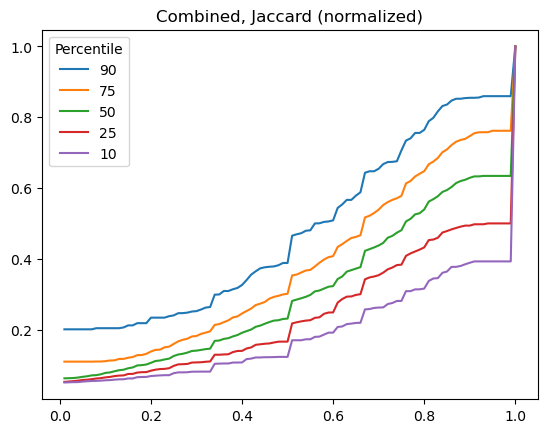

Cosine (normalized):   3%|▎         | 20/589 [00:10<03:33,  2.66it/s]

OutOfMemoryError: Out of memory allocating 1,261,856,768 bytes (allocated so far: 5,200,029,184 bytes).

Exception ignored in: 'cupy.cuda.thrust.cupy_malloc'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1424, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1445, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1116, in cupy.cuda.memory.SingleDeviceMemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1137, in cupy.cuda.memory.SingleDeviceMemoryPool._malloc
  File "cupy/cuda/memory.pyx", line 1382, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
  File "cupy/cuda/memory.pyx", line 1385, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
cupy.cuda.memory.OutOfMemoryError: Out of memory allocating 1,261,856,768 bytes (allocated so far: 5,200,029,184 bytes).
Cosine (normalized):  25%|██▌       | 149/589 [00:32<00:54,  8.08it/s]

OutOfMemoryError: Out of memory allocating 2,347,778,048 bytes (allocated so far: 5,863,579,136 bytes).

Exception ignored in: 'cupy.cuda.thrust.cupy_malloc'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1424, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1445, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1116, in cupy.cuda.memory.SingleDeviceMemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1137, in cupy.cuda.memory.SingleDeviceMemoryPool._malloc
  File "cupy/cuda/memory.pyx", line 1382, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
  File "cupy/cuda/memory.pyx", line 1385, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
cupy.cuda.memory.OutOfMemoryError: Out of memory allocating 2,347,778,048 bytes (allocated so far: 5,863,579,136 bytes).
Cosine (normalized):  33%|███▎      | 194/589 [00:41<00:55,  7.14it/s]

OutOfMemoryError: Out of memory allocating 2,801,417,728 bytes (allocated so far: 5,863,579,136 bytes).

Exception ignored in: 'cupy.cuda.thrust.cupy_malloc'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1424, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1445, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1116, in cupy.cuda.memory.SingleDeviceMemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1137, in cupy.cuda.memory.SingleDeviceMemoryPool._malloc
  File "cupy/cuda/memory.pyx", line 1382, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
  File "cupy/cuda/memory.pyx", line 1385, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
cupy.cuda.memory.OutOfMemoryError: Out of memory allocating 2,801,417,728 bytes (allocated so far: 5,863,579,136 bytes).
Cosine (normalized): 100%|██████████| 589/589 [02:50<00:00,  3.45it/s]

Cosine (normalized) failed on 17 files.


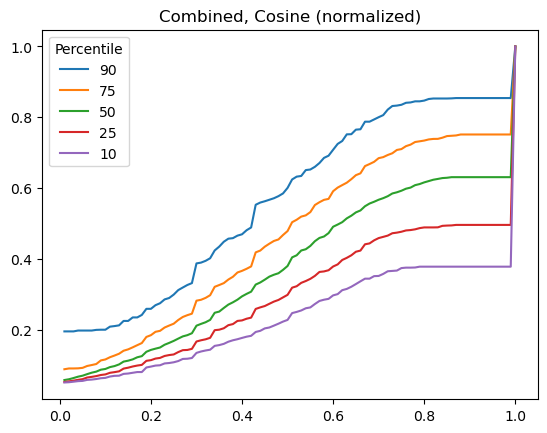

Simrank (normalized): 100%|██████████| 589/589 [10:18<00:00,  1.05s/it]

Simrank (normalized) failed on 23 files.


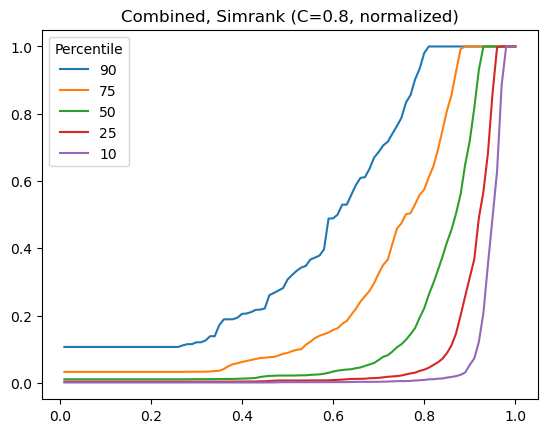

Jaccard (-0.5): 100%|██████████| 589/589 [01:36<00:00,  6.11it/s]

Jaccard (-0.5) failed on 125 files.


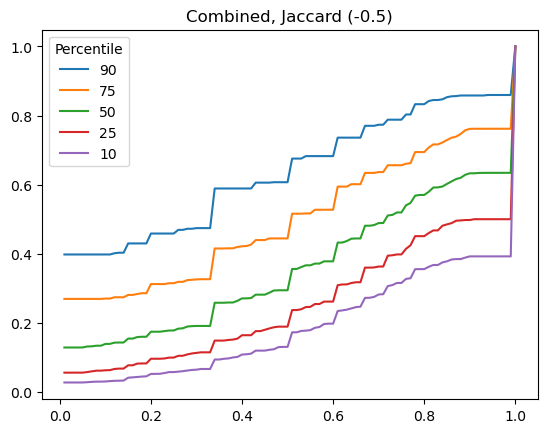

In [29]:
for name, metric, dirname, title in metrics:
    failures = []
    data = []
    for file in tqdm(glob('./data_all/*.pb'), desc=name):
        meta, projects, votes = load_pb_ohe(file)
        votes = cp.asarray(votes)

        try:
            dist = metric(votes)
        except Exception as e:
            failures.append(file)
            del meta, projects, votes
            continue
        hist, bins = np.histogram(
            dist.get().reshape(-1),
            bins=100,
            range=(0, 1),
            density=True,
        )
        cdf = np.cumsum(hist) * (bins[1] - bins[0])
        data.append(cdf)
    print(f"{name} failed on {len(failures)} files.")
    data = np.sort(np.array(data), axis=0)

    n = data.shape[0]
    lines = [
        (p, p * n // 100 - 1)
        for p in [90, 75, 50, 25, 10]
    ]
    for label, i in lines:
        plt.plot(bins[1:], data[i,:], label=label)
    plt.title(title % "Combined")
    plt.legend(title="Percentile")
    plt.show()
    plt.clf()
    plt.close()

## Correlations

In [6]:
def has_constant_value(d: dict) -> bool:
    for x in d.values():
        if np.all(np.isclose(x, x[0])):
            return True
    return False


In [ ]:
corrs = {
    (k1, k2): []
    for k1, _, _, _ in metrics
    for k2, _, _, _ in metrics
}
failures = []

data = []

for file in tqdm(glob('./data_all/*.pb')):
    _, _, votes = load_pb_ohe(file)
    votes = cp.asarray(votes)
    basename = path.splitext(path.basename(file))[0]

    try:
        d = dict()
        for name, metric, _, _ in metrics:
            d[name] = metric(votes).reshape(-1).get()
    except Exception as e:
        # print(f"Can't analyze file {file}.")
        # print(f"{votes.shape=}")
        # print(e)
        failures.append(file)
        del _, votes
        continue

    if has_constant_value(d):
        print(f"instance {basename} has constatnt distances")
        continue

    for k1, v1 in d.items():
        for k2, v2 in d.items():
            # Correlations
            corrs[(k1, k2)].append(stats.pearsonr(v1, v2).statistic)
            # Scatter plot
            dirname = f"scatter/{k1}-{k2}"
            os.makedirs(dirname, exist_ok=True)
            filename = f"{dirname}/{basename}.png"
            plt.xlabel(k1)
            plt.ylabel(k2)
            plt.scatter(v1, v2, s=5)
            plt.savefig(filename, dpi=150)
            plt.clf()
            plt.close()
    
    del _, votes, d

print(f"Failed on {len(failures)} files.")
print(failures)

corrs = {
    k: np.array(v)
    for k, v in corrs.items()
}

  0%|          | 0/589 [00:00<?, ?it/s]

 13%|█▎        | 78/589 [53:15<1:58:47, 13.95s/it]  

instance poland_gdynia_2020_wielki-kack-large has constatnt distances


 35%|███▍      | 204/589 [3:02:43<10:35:59, 99.11s/it] 

In [10]:
for (k1, k2), v in sorted(corrs.items()):
    if k1 < k2:
        desc = stats.describe(v)
        print(f"{k1:20} & {k2:20} :   mean={desc.mean:.4f}, variance={desc.variance:.4f}, min={desc.minmax[0]:.4f}, max={desc.minmax[1]:.4f}")

Cosine               & Cosine (normalized)  :   mean=0.9927, variance=0.0001, min=0.9497, max=1.0000
Cosine               & Jaccard              :   mean=0.9614, variance=0.0001, min=0.9363, max=1.0000
Cosine               & Jaccard (-0.5)       :   mean=0.9719, variance=0.0006, min=0.6464, max=1.0000
Cosine               & Jaccard (normalized) :   mean=0.9698, variance=0.0001, min=0.9398, max=1.0000
Cosine               & Simrank              :   mean=0.7316, variance=0.0295, min=0.2336, max=0.9996
Cosine               & Simrank (normalized) :   mean=0.7402, variance=0.0279, min=0.2390, max=1.0000
Cosine (normalized)  & Jaccard              :   mean=0.9347, variance=0.0010, min=0.8046, max=1.0000
Cosine (normalized)  & Jaccard (-0.5)       :   mean=0.9701, variance=0.0006, min=0.6464, max=1.0000
Cosine (normalized)  & Jaccard (normalized) :   mean=0.9705, variance=0.0002, min=0.9429, max=1.0000
Cosine (normalized)  & Simrank              :   mean=0.6890, variance=0.0361, min=0.2209, m

In [17]:
C = 0.8
corrs = []

for file in tqdm(glob('./data_all/*.pb')):
    _, _, votes = load_pb_ohe(file)
    votes = cp.asarray(votes)
    basename = path.splitext(path.basename(file))[0]

    try:
        d_jaccard = dist_gpu.jaccard(votes, votes).reshape(-1).get()
        d_simrank = dist_gpu.simrank(votes, C1=C, C2=C, max_iter=1000).reshape(-1).get()
    except Exception as e:
        # print(f"Can't analyze file {file}.")
        # print(f"{votes.shape=}")
        # print(e)
        failures.append(file)
        del _, votes
        continue

    if np.all(np.isclose(d_jaccard, d_jaccard[0])) or np.all(np.isclose(d_simrank, d_simrank[0])):
        print(f"instance {basename} has constatnt distances")
        continue

    corrs.append((stats.pearsonr(d_jaccard, d_simrank).statistic, basename, np.std(d_jaccard), np.std(d_simrank)))

    del _, votes, d_jaccard, d_simrank

 13%|█▎        | 79/589 [00:31<01:14,  6.88it/s]

instance poland_gdynia_2020_wielki-kack-large has constatnt distances


 57%|█████▋    | 335/589 [02:31<01:21,  3.10it/s]

instance poland_warszawa_2018_pole-mokotowskie has constatnt distances


 58%|█████▊    | 343/589 [02:33<00:45,  5.38it/s]

instance poland_warszawa_2018_przyczolek-grochowski has constatnt distances
instance poland_warszawa_2018_radiowo-wolka-weglowa-placowka-huta has constatnt distances


 74%|███████▎  | 433/589 [02:57<00:25,  6.00it/s]

instance poland_warszawa_2019_radiowo-wolka-weglowa-placowka-huta has constatnt distances


100%|██████████| 589/589 [04:07<00:00,  2.38it/s]


In [18]:
corrs.sort(key=lambda x: x[0])
corrs

[(np.float64(0.19875917490639958),
  'poland_warszawa_2019_rejon-poludniowy',
  np.float64(0.31056094150179475),
  np.float64(0.054710144406817804)),
 (np.float64(0.2125605571061709),
  'poland_warszawa_2019_las',
  np.float64(0.3470367395210599),
  np.float64(0.10258425455356363)),
 (np.float64(0.24846435192465896),
  'netherlands_amsterdam_604_',
  np.float64(0.2004753344911991),
  np.float64(0.03175597610338525)),
 (np.float64(0.27646956701459596),
  'poland_warszawa_2018_wysokie-okecie',
  np.float64(0.29269586478256154),
  np.float64(0.07380466043157059)),
 (np.float64(0.27746408580054727),
  'poland_warszawa_2019_targowek-fabryczny-elsnerow-i-utrata',
  np.float64(0.32164703622406976),
  np.float64(0.09861519255384088)),
 (np.float64(0.2826607986084249),
  'poland_warszawa_2018_bialoleka-obszar-3',
  np.float64(0.2530424865567154),
  np.float64(0.05422258627149961)),
 (np.float64(0.2863139058977998),
  'poland_warszawa_2019_stara-ochota',
  np.float64(0.3307414287566683),
  np.fl

In [ ]:
print(stats.pearsonr([x[0] for x in corrs], [x[2] - x[3] for x in corrs]))

PearsonRResult(statistic=np.float64(-0.43316665377974706), pvalue=np.float64(7.928042059929775e-23))
PearsonRResult(statistic=np.float64(-0.43316665377974706), pvalue=np.float64(7.928042059929775e-23))
